In [ ]:
#import important python packages pandas for data processing/analysis/presentation
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
import jinja2
import shap
from xgboost import XGBRegressor, plot_importance
import category_encoders as ce # binary encoding
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
#from sklearn.linear_model import HuberRegressor
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr, spearmanr, pointbiserialr



pd.set_option('display.max_columns', None) # set dataframe output to display all columns 
pd.set_option('display.max_rows', None) # set dataframe output to display all rows in output
pd.set_option("display.max_colwidth", None) # set dataframe output to display all output for each column
#pd.set_option('display.float_format', '{:.8f}'.format)

# import the updated netflix dataset from Assignment2
nds = pd.read_csv("dataset/nds_z_scores.csv")

#print out summary info
nds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3273 entries, 0 to 3272
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      3273 non-null   int64  
 1   index           3273 non-null   int64  
 2   Title           3273 non-null   object 
 3   Director        3273 non-null   object 
 4   Cast            3028 non-null   object 
 5   Country         3273 non-null   object 
 6   Release_Date    3273 non-null   object 
 7   Rating          3273 non-null   object 
 8   Duration        3273 non-null   int64  
 9   Type            3273 non-null   object 
 10  Description     3273 non-null   object 
 11  IMDB_Rating     3273 non-null   float64
 12  IMDB_Votes      3273 non-null   int64  
 13  Release_Year    3273 non-null   int64  
 14  Z_Duration      3273 non-null   float64
 15  Z_IMDB_Rating   3273 non-null   float64
 16  Z_Release_Year  3273 non-null   float64
 17  Z_IMDB_Votes    3273 non-null   f

In [19]:
# remove irrelevant columns
nds_clean = nds.copy()
nds_clean = nds_clean.drop(['Unnamed: 0','index','Release_Date', 'Z_Duration','Z_Duration','Z_Release_Year', 'Z_IMDB_Votes','Z_IMDB_Rating'], axis=1)
nds_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3273 entries, 0 to 3272
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           3273 non-null   object 
 1   Director        3273 non-null   object 
 2   Cast            3028 non-null   object 
 3   Country         3273 non-null   object 
 4   Rating          3273 non-null   object 
 5   Duration        3273 non-null   int64  
 6   Type            3273 non-null   object 
 7   Description     3273 non-null   object 
 8   IMDB_Rating     3273 non-null   float64
 9   IMDB_Votes      3273 non-null   int64  
 10  Release_Year    3273 non-null   int64  
 11  log_IMDB_Votes  3273 non-null   float64
dtypes: float64(2), int64(3), object(7)
memory usage: 307.0+ KB


 ### Columns and their ordinality (True/False)
 
| ``#`` | Column         | Non-Null Count  | Dtype    | Ordinal |  
|  ---  | ------         | -------------   | ------   | ------- |
|   0   | Title          | 3273 non-null   | object   |         | 
|   1   | Director       | 3273 non-null   | object   |   F     |        
|   2   | Cast           | 3028 non-null   | object   |   F     |        
|   3   | Country        | 3273 non-null   | object   |   F     |        
|   4   | Rating         | 3273 non-null   | object   |   F     |        
|   5   | Duration       | 3273 non-null   | int64    |   F     |        
|   6   | Type           | 3273 non-null   | object   |   F     |        
|   7   | Description    | 3273 non-null   | object   |   F     |        
|   8   | IMDB_Rating    | 3273 non-null   | float64  |   T     |        
|   9   | IMDB_Votes     | 3273 non-null   | int64    |   T     |        
|   10  | Release_Year   | 3273 non-null   | int64    |   F     |        
|   11  | log_IMDB_Votes | 3273 non-null   | float64  |   T     |        


Only IMDB_Rating and IMDB_Votes have ordinal values. 





___
### Exploratory Data Analysis - Columns with comma separated strings

**Find out the statistics for columns which contain comma separated values***

*eg movie datapoint at index 1 has a Type (Genre) column value containing a single (comma separated) string listing 3x types/genres: *'Action & Adventure, Independent Movies, Sci-Fi & Fantasy'*

There are 5 columns with these comma separated strings:
- **Director** 
- **Cast**   
- **Country** 
- **Type (i.e. Genre)**  
- **Description** → extremely high cardinality; likely to be very weak influence on IMDB Rating; likely to substantially increase dimensionality. Ignored here.

The below code defines:
- Table showing cardinality of each column
- Table showing:
    - total number of individual values per column
    - number of rows containing CSV's per column (ie some rows contain only one value, not multiple comma separated)
    - % of rows with containing CSV's per column
    - average CSV size per row, per column
- Tables showing, per column, how many rows have n (can be comma separated) values for each value of n


#### **↓↓ Code described here follows below ↓↓** ##

In [20]:
# create dataframe to work with
nds_eda = nds_clean.copy()
pd.options.display.float_format = '{:.2f}'.format

In [21]:
# get cardinality of each column 

cat_columns = ["Director","Cast","Country","Type"]

column_card = pd.DataFrame(columns=['Column Name', 'Cardinality (Unique Values)'])
print("Column Cardinality (Unique Values)")
print("-"*12)
for c in cat_columns:
    column_card.loc[len(column_card)] = [c, len(np.unique(sum(nds_eda[c].str.split(',').dropna().to_numpy(), [])))]
column_card.style.hide()


Column Cardinality (Unique Values)
------------


Column Name,Cardinality (Unique Values)
Director,2978
Cast,17023
Country,161
Type,35


In [22]:
# Table showing total number of individual values per column, the number of rows with CSVs per column, 
# and the % of rows with CSVs per column, and average number of values per row

print("Comma Separated Values Per Column")
column_csv = pd.DataFrame(columns=['Column Name', 'Total Values', '# Rows with Comma Separated values', \
                                    '% rows with Comma Separated values', 'Average CS Values / row'])
for c in cat_columns:
    column_csv.loc[len(column_csv)] = [c, nds_eda[c].str.split(',').explode(c).value_counts().sum(), \
                                nds_eda[c].str.contains(',').value_counts().values[1], \
                                round(nds_eda[c].str.contains(',').value_counts().values[1]/(0.01*nds_eda.shape[0]),1), \
                                (nds_eda[c].str.count(',', re.I)+1).mean().round(2)   ]

pd.options.display.float_format = '{:.2f}'.format
column_csv.head()


Comma Separated Values Per Column


,Column Name,Total Values,# Rows with Comma Separated values,% rows with Comma Separated values,Average CS Values / row
0,Director,3706,328,10.00,1.13
1,Cast,23862,367,11.20,7.88
2,Country,4335,678,20.70,1.32
3,Type,6918,831,25.40,2.11


In [23]:
# calculate how many Director rows have ONLY n (comma separated) values for each value of n

column_dir = pd.DataFrame(columns=['n values in row (only)', '# rows with n values'])

# save count of values (comma separated) per row in new feature Director_Count
nds_eda["Director_Count"] = nds_eda['Director'].apply(lambda c: c.count(',')+1 if ',' in c else 1)
print(f"Director Column")
print("-"*12)

for values, count in nds_eda["Director_Count"].value_counts().items():
    column_dir.loc[len(column_dir)] = [values, count]

column_dir.style.hide()


Director Column
------------


n values in row (only),# rows with n values
1,2945
2,297
3,15
4,5
5,3
11,2
13,2
10,1
9,1
12,1


In [24]:
# calculate how many Cast rows have ONLY n (comma separated) values for each value of n

# change NA values in Cast feature to No-Actors (which is a more descriptive term and the category may have a valid relationship to IMDB Rating)
nds_eda['Cast'] = nds_eda['Cast'].fillna('No Actors') 

column_cast = pd.DataFrame(columns=['n values in row (only)', '# rows with n values'])
# save count of values (comma separated) per row in new feature Cast_Count
nds_eda["Cast_Count"] = nds_eda['Cast'].apply(lambda c: c.count(',')+1 if ',' in c else 1)
print(f"Cast Column")
print("-"*12)
#nds_eda['Cast'].apply(lambda a: a.str.count(',')+1 if ',' in a else np.nan)
# print total number of rows for those rows that have n comma separated values
for values, count in nds_eda["Cast_Count"].value_counts().items():
    column_cast.loc[len(column_cast)] = [values, count]

column_cast.style.hide()

Cast Column
------------


n values in row (only),# rows with n values
10,631
1,612
8,488
9,303
6,211
7,210
11,205
5,123
12,122
4,74


In [25]:
nds_eda.shape

(3273, 14)

In [26]:
# calculate how many Country rows have ONLY n (comma separated) values for each value of n

column_cty = pd.DataFrame(columns=['n values in row (only)', '# rows with n values'])

# save count of values (comma separated) per row in new feature Cast_Count
nds_eda["Country_Count"] = nds_eda['Country'].apply(lambda c: c.count(',')+1 if ',' in c else 1)
print(f"Country Column")
print("-"*12)

# print total number of rows for those rows that have n comma separated values
for values, count in nds_eda["Country_Count"].value_counts().items():
    column_cty.loc[len(column_cty)] = [values, count]
column_cty.style.hide()

Country Column
------------


n values in row (only),# rows with n values
1,2595
2,445
3,140
4,59
5,21
6,6
7,5
10,1
8,1


In [27]:
# calculate how many Type (Genre) rows have ONLY n (comma separated) values for each value of n

column_gen = pd.DataFrame(columns=['n values in row (only)', '# rows with n values'])
# save count of values (comma separated) per row in new feature Cast_Count
nds_eda["Type_Count"] = nds_eda['Type'].apply(lambda c: c.count(',')+1 if ',' in c else 1)
print(f"Type (Genre) Column")
print("-"*12)

# print total number of rows for those rows that have n comma separated values
for values, count in nds_eda["Type_Count"].value_counts().items():
    column_gen.loc[len(column_gen)] = [values, count]

#column_gen.head(15)
column_gen.style.hide()

Type (Genre) Column
------------


n values in row (only),# rows with n values
2,1239
3,1203
1,831


___
### Feature Engineering 

##### **Change Type Column name to Genre, for ease of understanding**
With the context of movies, Genre has less ambiguity about the columns meaning. 


##### **Create new features from columns which contain comma separated values**

This is to allow chosen models to recognise the influence of each Director/Actor/country/Genre and not comma separated strings as per the original dataset.

- **Director** - High cardinality (2918 unique values). Less than 1% of data points have more then 2 directors, less than 9% have 2 directors, and 90% only have 1 director. To avoid introducing bias with imputation, and also avoid introducing unnecessary extra dimensionality, and thus potential overfitting, only the first directors name will become a feature. New feature: *First_Director*
- **Cast** - Huge cardinality (16k+ unique values), average 7.4 actors per row. 78% or rows have 3 or more actors.This category starts with lead actors first, so very likely declining influence on movie from actors later in the comma separated string. New features: *First_Actor* *Second_Actor*, *Third_Actor*  
- **Country** - Moderate cardinality (161 unique values). Avg values in column = 1.33. Almost 80% have only 1 country listed. As with Cast feature, most important country values listed first in comma separated string, so will limit to first listed country to avoid introducing bias/extra dimensionality: New feature: *First_Country*
- **Genre (formerly 'Type')** - Moderate/low cardinailty, only 35 unique values. Netflix lists up to 3 Genres in alphabetical order. ie unlike director/cast/country, Netflix doesnt create any order based on importance. 75% of rows have at least 2 types/genres. However, only 1186 rows have 3 Genres (2036 empty [ie 1221+815]), so with 63% empty values there is too much risk of introducing bias/distorting results, and so will create features: *First_Genre*, *Second_Genre*
- **Description** - Delete column.

The above new features creation is a balance between between retinaing as much informatino as possible and losing information (features with very few values) that should have minimal impact on modelling.

##### **Handling Missing values**

For the Cast feature, some are empty. eg Avant Garde movies with no cast. I will change empty values in Cast feature to 'No-Actors', which is a more descriptive term and the category may have a valid relationship to IMDB Rating.

Some of the new (CSV) features defined above include missing values. They cant be left empty for the testing and modelling as not all models can handle missing values. So all empty values will have the string 'Missing' inserted. Deleting the relevant rows (there are several hundred) is not possible with such a small dataset.

However, this leads to another problem - it is possible that formerly empty values (ie set to string 'Missing') may create a false association with the target variable, i.e. some Machine Learning algorithms may think 'Missing' is a real category, which will distort results. Alternatively, there may be an actual association between not having say, a second director, and having a low IMDb rating.  To verify this, I will create a new 'Missing_COLUMN_NAME' feature, binary encoded, for each feature with missing values. This will allow the original categorical feature (where empty values = 'Missing') to be available for feature selection testing. This allows me to determine if the absence of a feature value correlates with the target variable.   


#### **↓↓ Code described here follows below ↓↓** ##

In [28]:
nds_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3273 entries, 0 to 3272
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           3273 non-null   object 
 1   Director        3273 non-null   object 
 2   Cast            3028 non-null   object 
 3   Country         3273 non-null   object 
 4   Rating          3273 non-null   object 
 5   Duration        3273 non-null   int64  
 6   Type            3273 non-null   object 
 7   Description     3273 non-null   object 
 8   IMDB_Rating     3273 non-null   float64
 9   IMDB_Votes      3273 non-null   int64  
 10  Release_Year    3273 non-null   int64  
 11  log_IMDB_Votes  3273 non-null   float64
dtypes: float64(2), int64(3), object(7)
memory usage: 307.0+ KB


In [29]:
# Change Type Column name to Genre, for ease of understanding
nds_clean.rename(columns={'Type': 'Genre'}, inplace=True)

# change NA values in Cast feature to 'No-Actors' (which is a more descriptive term and the category may have a valid relationship to IMDB Rating)
nds_clean['Cast'] = nds_clean['Cast'].fillna('No Actors') 

In [30]:
# Create new features from columns which contain comma separated values

# Create new columns: First_Director
nds_clean['First_Director'] = nds_clean['Director'].apply(lambda x: x.split(',')[0])
# Create new columns: First_Actor, Second_Actor, Third_Actor
nds_clean['First_Actor'] = nds_clean['Cast'].apply(lambda x: x.split(',')[0])
nds_clean['Second_Actor'] = nds_clean['Cast'].apply(lambda x: x.split(',')[1] if ',' in x else np.nan)
nds_clean['Third_Actor'] = nds_clean['Cast'].apply(lambda x: x.split(',')[2] if (',' in x and x.count(',') > 1) else np.nan)
# Create new columns: First_Country
nds_clean['First_Country'] = nds_clean['Country'].apply(lambda x: x.split(',')[0])
# Create new columns: First_Genre, Second_Genre (From Type column - renamed to Genre for better title clarity) 
nds_clean['First_Genre'] = nds_clean['Genre'].apply(lambda x: x.split(',')[0])
nds_clean['Second_Genre'] = nds_clean['Genre'].apply(lambda x: x.split(',')[1] if ',' in x else np.nan)


In [31]:
nds_clean.isna().sum()

Title               0
Director            0
Cast                0
Country             0
Rating              0
Duration            0
Genre               0
Description         0
IMDB_Rating         0
IMDB_Votes          0
Release_Year        0
log_IMDB_Votes      0
First_Director      0
First_Actor         0
Second_Actor      612
Third_Actor       668
First_Country       0
First_Genre         0
Second_Genre      831
dtype: int64

<Axes: >

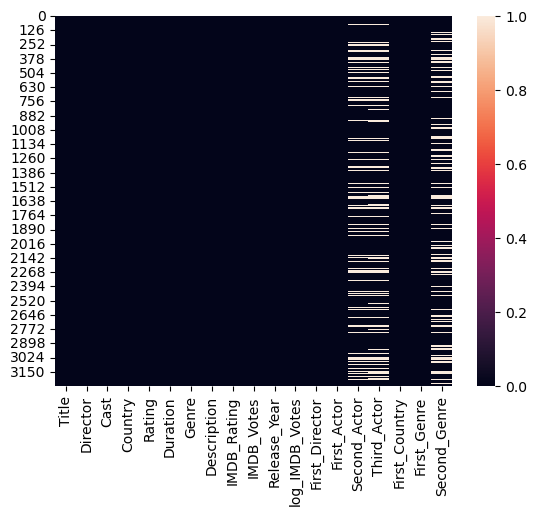

In [32]:
# display map showing null values per column
sns.heatmap(nds_clean.isnull())

<Axes: >

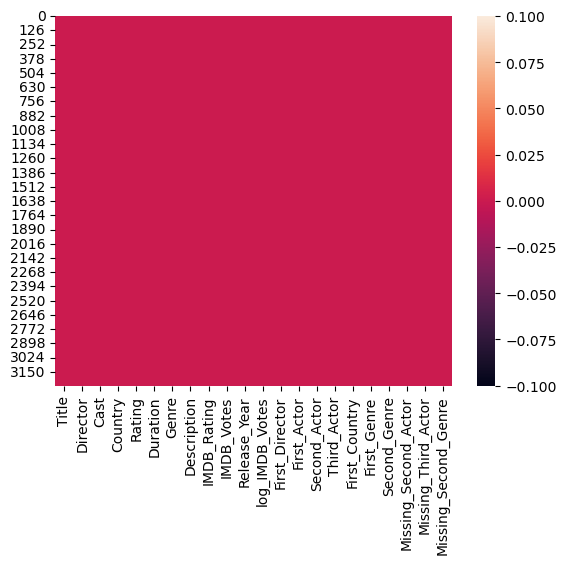

In [33]:
# Create 'Missing_x' columns & Handling Missing Values in original columns

# list of columns with missing values
missing_columns = ["Second_Actor","Third_Actor", "Second_Genre"] 

# create new 'Missing_X' columns with binary values for missing/not missing
for c in missing_columns:
    nds_clean['Missing_'+c] = nds_clean[c].isna().astype(int)
    nds_clean[c] = nds_clean[c].fillna('Missing')


# display map showing null values per column
sns.heatmap(nds_clean.isnull())


---
### Feature Selection - Mutual Information Regression (MIR)

Numerical columns:
- Release Date
- Duration
- IMDB_Votes 
- log_IMDB_Votes (log transformed IMDB_Votes column)

Numerical data composition:
- A mix of nominal/ordinal and discrete/continuous variables
- One has severe (but valid and informative) outliers (IMDb_Votes)
- Extremely wide scaling differences
- As per the scatterplot and Pearson/Spearman [1]/[2] correlations (shown below), the IMDB Rating (target variable) relationship, linear and/or monotonic (including if positive or negative), to numerical features is summarised here:  

| Feature        | Linear / monotonic  |
| -------------- | ------------------- |
| Release year   | no / no             |     
| Duration       | weak + / +          |
| IMDB_Votes     | moderate + / +      |
| log_IMDB_Votes | moderate + / +      |

The cataegorical features (Director, Actors, Rating, Country, Genre) have no numerical order or distance bewteen classes, so a linear relationship to target of proportional increasing/increasing (or increasing/decreasing) values is absent, even with encoding.

Given the above, I used Mutual Information Regression [3],[4],[5] filter method on features to capture dependencies with the target variable. Mutual information is suitable for both continuous and discrete variables and can capture non-linear as well as linear relationships. However, it is sensitive to feature scales, so I standardized the feature data. Embedded feature selection using RandomForestRegressor will also be used further down.

### Feature Selection - Mutual Information Regression - Results 
The MIR score shows a clear dependency between IMDB_Votes and IMDB_Rating/log_IMDB_Rating. When the log adjusted IMDB Votes feature is used, the dependency between the two is marginally stronger. Scaled Vs. original features also produced only slight differences in results (see code, below.)
The top 4 Features with identified dependencies to the target were:  
| Feature              | 
| ----------------     |
| IMDB_Votes (+log)    |    
| First_Genre          | 
| Duration             |
| Missing_Second_Actor | 

After the above features, the below features (Starting from the top, going down) had increasingly weaker dependencies identified by MIR:  
| Feature               |
| --------------------- |
| Missing_Third_Actor   |
| Second_Genre          |
| Missing_Second_Genre  |
| First_Actor           |
| Second_Actor          |
| Release_Year          |
| Rating                |
| First_Director        |
| First_Country         |



[1] GeeksforGeeks. (2020, April 6). Pearson Correlation Test Between Two Variables Python. GeeksforGeeks. https://www.geeksforgeeks.org/python/python-pearson-correlation-test-between-two-variables/  
[2] GeeksforGeeks. (2020, August 15). Spearman’s Rank Correlation. GeeksforGeeks. https://www.geeksforgeeks.org/data-science/spearmans-rank-correlation/  
[3] GeeksforGeeks. (2024, April 15). Information Gain and Mutual Information for Machine Learning. GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/information-gain-and-mutual-information-for-machine-learning/  
‌[4] sole. (2022, August 12). Mutual information with Python. Train in Data Blog. https://www.blog.trainindata.com/mutual-information-with-python/         
‌[5] sklearn.feature_selection.mutual_info_regression. (n.d.). Scikit-Learn. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html



#### **↓↓ Code described here follows below ↓↓** ##



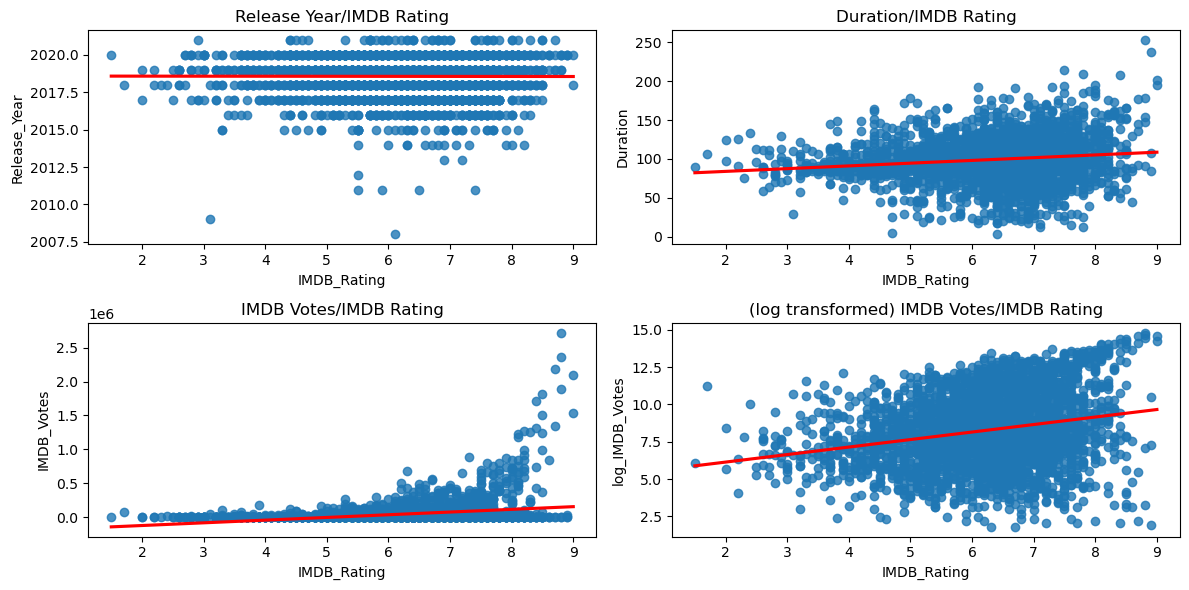

In [34]:
# Create scatter plots to show relationship of target variable (IMDB Rating) to numerical features
# this shows mostly weak to moderate linearity (for Duration/IMDB_Rating) and no relationship (ie random scatter) for Release_Year

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))


sns.regplot(x="IMDB_Rating",y="Release_Year",line_kws={"color": "red"},data=nds_clean,ci=None,ax=axs[0,0]).set(title='Release Year/IMDB Rating')
sns.regplot(x="IMDB_Rating",y="Duration",line_kws={"color": "red"},data=nds_clean,ci=None,ax=axs[0,1]).set(title='Duration/IMDB Rating')
sns.regplot(x="IMDB_Rating",y="IMDB_Votes",line_kws={"color": "red"},data=nds_clean,ci=None,ax=axs[1,0]).set(title='IMDB Votes/IMDB Rating')
sns.regplot(x="IMDB_Rating",y="log_IMDB_Votes",line_kws={"color": "red"},data=nds_clean,ci=None,ax=axs[1,1]).set(title='(log transformed) IMDB Votes/IMDB Rating')



plt.tight_layout()
plt.show()

In [35]:
# for numerical features relationship to target variable: 
# pearsons correlation to determine if linear relationship
# spearman correlation to detect monotonic relationship 

numeric_features = ["Release_Year","Duration", "IMDB_Votes", "log_IMDB_Votes"]
pr = pd.DataFrame(columns=["Feature Name","Pearson","Spearman"])
for feature in numeric_features:  
    pcorr, _  = pearsonr(nds_clean[feature], nds_clean['IMDB_Rating'])
    scorr = spearmanr(nds_clean[feature], nds_clean['IMDB_Rating']).correlation
    pr.loc[len(pr)] = [feature,f"{round(pcorr,3)}",scorr]
pr.head()

,Feature Name,Pearson,Spearman
0,Release_Year,-0.003,-0.01
1,Duration,0.148,0.15
2,IMDB_Votes,0.28,0.21
3,log_IMDB_Votes,0.233,0.21


In [36]:
# Mutual Information testing: create new dataframe, remove redundant columns and encode categorical features

# Categorical columns to be encoded
cat_columns = ["Rating","First_Director","First_Actor", "Second_Actor","Third_Actor", \
                 "First_Country","First_Genre","Second_Genre"] 

# create Mutual Information Regression (MIR) dataframe and remove redundant columns
nds_mir = nds_clean.drop(['Title','Director','Cast','Country','Genre','Description'], axis=1).copy()

# Initialize and fit LabelEncoder on categorical features to be tested
le = LabelEncoder()
for f in cat_columns:
    nds_mir[f] = LabelEncoder().fit_transform(nds_mir[f])




In [37]:
nds_mir.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3273 entries, 0 to 3272
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Rating                3273 non-null   int64  
 1   Duration              3273 non-null   int64  
 2   IMDB_Rating           3273 non-null   float64
 3   IMDB_Votes            3273 non-null   int64  
 4   Release_Year          3273 non-null   int64  
 5   log_IMDB_Votes        3273 non-null   float64
 6   First_Director        3273 non-null   int64  
 7   First_Actor           3273 non-null   int64  
 8   Second_Actor          3273 non-null   int64  
 9   Third_Actor           3273 non-null   int64  
 10  First_Country         3273 non-null   int64  
 11  First_Genre           3273 non-null   int64  
 12  Second_Genre          3273 non-null   int64  
 13  Missing_Second_Actor  3273 non-null   int64  
 14  Missing_Third_Actor   3273 non-null   int64  
 15  Missing_Second_Genre 

In [38]:
# create dataframe, standardize numerical features and perform Mutual Information Regression



# function to calculate mutual infromation regression scores of features against target var
def mutual_Info (df,votes="log_IMDB_Votes",scaled=False):
    if scaled:
        X = pd.DataFrame(StandardScaler().set_output(transform="pandas").fit_transform(df.drop(["IMDB_Rating",votes], axis=1)))
    else:
        X = df.drop(["IMDB_Rating",votes], axis=1)
    y = df["IMDB_Rating"]  
    # split the dataset into test/train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)
    # train model
    mir = mutual_info_regression(X_train, y_train, random_state=0)
    # calculate and print MIR values
    mir = pd.Series(mir, name="MIR_Score")
    mir.index = X_train.columns
    mir.sort_values(ascending=False, inplace=True)
    print(f"\nMIR scores {"(Scaled)" if scaled  else ""}:")
    return mir


# specify features (with original IMDB Votes values) then calculate MIR scores
print(mutual_Info(nds_mir))

# specify features (with IMDB Votes log values) and then calculate MIR scores
print(mutual_Info(nds_mir,votes="IMDB_Votes"))

# specify features (all features scaled with StandardScaler) then calculate MIR scores
print(mutual_Info(nds_mir,scaled=True))

# specify features (all features scaled with StandardScaler) then calculate MIR scores
print(mutual_Info(nds_mir,votes="IMDB_Votes",scaled=True))


MIR scores :
IMDB_Votes             0.11
First_Genre            0.08
Duration               0.08
Missing_Second_Actor   0.05
Third_Actor            0.04
First_Actor            0.04
Rating                 0.04
Missing_Third_Actor    0.03
Second_Genre           0.02
Second_Actor           0.01
First_Director         0.01
Missing_Second_Genre   0.01
First_Country          0.01
Release_Year           0.01
Name: MIR_Score, dtype: float64

MIR scores :
log_IMDB_Votes         0.13
First_Genre            0.08
Duration               0.08
Missing_Second_Actor   0.05
Third_Actor            0.04
First_Actor            0.04
Rating                 0.04
Missing_Third_Actor    0.03
Second_Genre           0.02
Second_Actor           0.01
First_Director         0.01
Missing_Second_Genre   0.01
First_Country          0.01
Release_Year           0.01
Name: MIR_Score, dtype: float64

MIR scores (Scaled):
IMDB_Votes             0.11
First_Genre            0.08
Duration               0.08
Missing_Second_Act

___
### Feature Selection - Random Forest Regressor (RFR)

Embedded feature selection using Random Forest Regressor algorithm with default hyper params

#### ***Encode categorical features***
NOTE: All categorical features here are nominal - i.e. have no inherent order 

- **(Maturity)Rating** - One-Hot encoding - Why? Low cardinality - only 12 categories; doesnt assume order
- **First_Director** - Binary encoding - Why? High cardinality (2k+ categories), minimise increasing dimensionality; doesnt assume order
- **First/Second/Third_Actor** - Binary encoding - Why? High cardinality (16k+ categories), minimise increasing dimensionality; doesnt assume order
- **First_Country** - Binary encoding - Why? High cardinality (161 categories), minimise increasing dimensionality; doesnt assume order
- **First/Second_Genre** - Binary encoding - Why? relatively low cardinality (35 categories), but with three columns to encode would lead to high dimensionality if one-hot; doesnt assume order

#### ***Scaling***

No scaling. Random Forest Regressor not sensitive to magnitude of features.

#### **↓↓ Code described here follows below ↓↓** ##

In [39]:
nds_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3273 entries, 0 to 3272
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Title                 3273 non-null   object 
 1   Director              3273 non-null   object 
 2   Cast                  3273 non-null   object 
 3   Country               3273 non-null   object 
 4   Rating                3273 non-null   object 
 5   Duration              3273 non-null   int64  
 6   Genre                 3273 non-null   object 
 7   Description           3273 non-null   object 
 8   IMDB_Rating           3273 non-null   float64
 9   IMDB_Votes            3273 non-null   int64  
 10  Release_Year          3273 non-null   int64  
 11  log_IMDB_Votes        3273 non-null   float64
 12  First_Director        3273 non-null   object 
 13  First_Actor           3273 non-null   object 
 14  Second_Actor          3273 non-null   object 
 15  Third_Actor          

In [40]:
# Create new dataframe and Encode categorical features

# create new dataframe to work with for Random Forest Regressor
nds_rfr = nds_clean.copy()

# - **(Maturity)Rating** - One-Hot encoding - Why? Low cardinality - only 12 categories; doesnt assume order
nds_rfr = pd.get_dummies(nds_rfr, columns=['Rating'], dtype = 'int', prefix='Maturity_Rating_')

# - **First_Director** - Binary encoding - Why? High cardinality (2k+ categories), minimise increasing dimensionality; doesnt assume order
fd_df = ce.BinaryEncoder(cols=['First_Director']).fit_transform(nds_rfr['First_Director'])

# - **First/Second/Third_Actor** - Binary encoding - Why? High cardinality (16k+ categories), minimise increasing dimensionality; doesnt assume order
fa_df = ce.BinaryEncoder(cols=['First_Actor']).fit_transform(nds_rfr['First_Actor'])
sa_df = ce.BinaryEncoder(cols=['Second_Actor']).fit_transform(nds_rfr['Second_Actor'])
ta_df = ce.BinaryEncoder(cols=['Third_Actor']).fit_transform(nds_rfr['Third_Actor'])

# - **First_Country** - Binary encoding - Why? High cardinality (161 categories), minimise increasing dimensionality; doesnt assume order
fc_df = ce.BinaryEncoder(cols=['First_Country']).fit_transform(nds_rfr['First_Country'])

# - **First/Second_Genre** - Binary encoding - Why? relatively low cardinality (35 categories), but with three columns to encode would lead to high dimensionality if one-hot; doesnt assume order
fg_df = ce.BinaryEncoder(cols=['First_Genre']).fit_transform(nds_rfr['First_Genre'])
sg_df = ce.BinaryEncoder(cols=['Second_Genre']).fit_transform(nds_rfr['Second_Genre'])


#add columns to working dataset nds_rfr
nds_rfr = pd.concat([nds_rfr, fd_df, fa_df, sa_df, ta_df, fc_df, fg_df, sg_df], axis = 1) 

# remove redundant columns
nds_rfr.drop(['Description', 'First_Director', 'First_Actor', 'Second_Actor' , 'Third_Actor','First_Country', 'First_Genre', 'Second_Genre', 'Title', 'Director', 'Cast', 'Country', 'Genre'], axis=1, inplace=True)

nds_rfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3273 entries, 0 to 3272
Data columns (total 85 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Duration                   3273 non-null   int64  
 1   IMDB_Rating                3273 non-null   float64
 2   IMDB_Votes                 3273 non-null   int64  
 3   Release_Year               3273 non-null   int64  
 4   log_IMDB_Votes             3273 non-null   float64
 5   Missing_Second_Actor       3273 non-null   int64  
 6   Missing_Third_Actor        3273 non-null   int64  
 7   Missing_Second_Genre       3273 non-null   int64  
 8   Maturity_Rating__G         3273 non-null   int64  
 9   Maturity_Rating__NC-17     3273 non-null   int64  
 10  Maturity_Rating__PG        3273 non-null   int64  
 11  Maturity_Rating__PG-13     3273 non-null   int64  
 12  Maturity_Rating__R         3273 non-null   int64  
 13  Maturity_Rating__TV-14     3273 non-null   int64

In [41]:
# run dataset with original IMDB_Votes values on RandomForestRegressor algorithm

# function to train dataset with RandomForestRegressor 
def rfr_predict(X,y,count=10,params={}):
    # split the dataset into test/train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
         
    rfr = RandomForestRegressor(**params)
    # fit RandomForestRegressor to training data
    rfr.fit(X_train, y_train)
    # predictions
    y_pred = rfr.predict(X_test.values)
    # evaluation with MAE and RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    evaluation = pd.DataFrame({
    "Actual": y_test[:count],
    "Predicted": y_pred[:count],
    "Error": np.abs(y_test[:count] - y_pred[:count])
    })
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"First {count} predictions:\n", evaluation)

    return rfr, X_train, X_test, y_test, y_pred # return for use outside function, eg XAI

# create testing dataframe by selecting features and target variable
X_rfr = nds_rfr.drop(['IMDB_Rating','log_IMDB_Votes'], axis=1)
y_rfr = nds_rfr['IMDB_Rating']

# train datasets on RandomForestRegressor and extract eval metrics
model, X_train, X_test, y_test, y_pred = rfr_predict(X=X_rfr,y=y_rfr)




RMSE: 0.92
MAE: 0.69
First 10 predictions:
       Actual  Predicted  Error
909     5.00       5.56   0.56
1236    6.60       7.03   0.43
1080    7.70       6.10   1.60
2804    7.10       5.93   1.17
1342    7.00       6.64   0.36
2567    5.80       6.50   0.70
2975    6.40       6.81   0.41
1027    7.20       5.67   1.53
709     5.20       5.96   0.76
2800    5.30       6.27   0.97


c:\Users\luke\anaconda3\envs\comp647\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [42]:
# run dataset with log transformed IMDB_Votes values on RandomForestRegressor algorithm

# create testing dataframe by selecting features and target variable
X_rfr_Vlog = nds_rfr.drop(['IMDB_Rating','IMDB_Votes'], axis=1)
y_rfr_Vlog = nds_rfr['IMDB_Rating']

# train datasets on RandomForestRegressor and extract eval metrics
model_Vlog, X_train_Vlog, X_test_Vlog, y_test_Vlog, y_pred_Vlog = rfr_predict(X=X_rfr_Vlog,y=y_rfr_Vlog)


RMSE: 0.91
MAE: 0.68
First 10 predictions:
       Actual  Predicted  Error
909     5.00       5.46   0.46
1236    6.60       7.17   0.57
1080    7.70       6.24   1.46
2804    7.10       6.14   0.96
1342    7.00       6.64   0.36
2567    5.80       6.45   0.65
2975    6.40       6.99   0.59
1027    7.20       5.85   1.35
709     5.20       6.03   0.83
2800    5.30       6.19   0.89


c:\Users\luke\anaconda3\envs\comp647\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


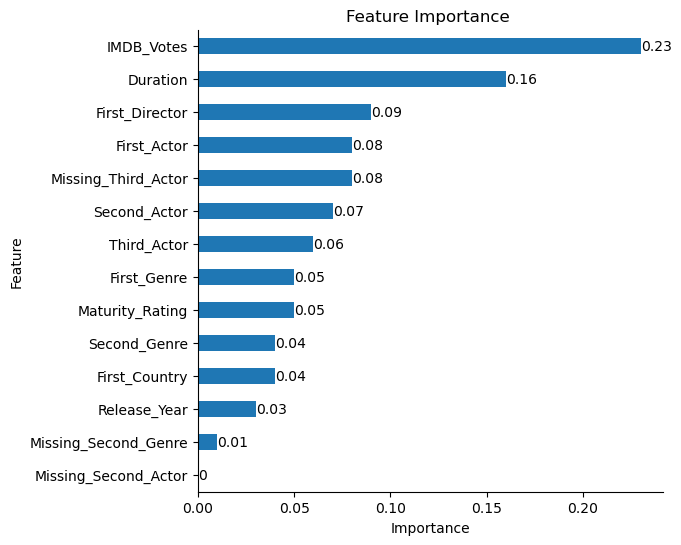

In [43]:
# feature selection: RandomForestRegressor feature importance (default hyper params) graph plotted


def feature_select(model,X_train,title=""):
    feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)
    grouped_features = {}
    # iterate through multiple column feature values belonging to single binary encoded feature and sum the values
    encoded = ("First_Dir","First_Act","Second_Act","Third_Act","First_Cou","First_Gen","Second_Gen","Maturity_Rat") 
    for column,importance in feature_importance.items():   
        if column.startswith(encoded):
            prefix = f"{column.split('_')[0]}_{column.split('_')[1]}"
        else:
            prefix = column
        grouped_features[prefix] = grouped_features.get(prefix,0)+importance
        #print(f"Col: {column}, Imp: {importance}, grouped: {grouped_features[prefix]}")

    # list only features above a certain importance threshold
    threshold = 0.01
    features_threshold = {}
    for k,v in grouped_features.items():
        if v > 0.001:
            features_threshold[k] = v
    importance_grouped = pd.Series(features_threshold).sort_values().round(decimals=2)
    ax = importance_grouped.plot(kind="barh", title="Feature Importance",figsize=(6,6), xlabel="Importance", ylabel="Feature")
    ax.bar_label(ax.containers[0])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(f"Feature Importance {title}")
    plt.show()

# Plot feature importance with original IMDB_Votes values
feature_select(model=model,X_train=X_train)


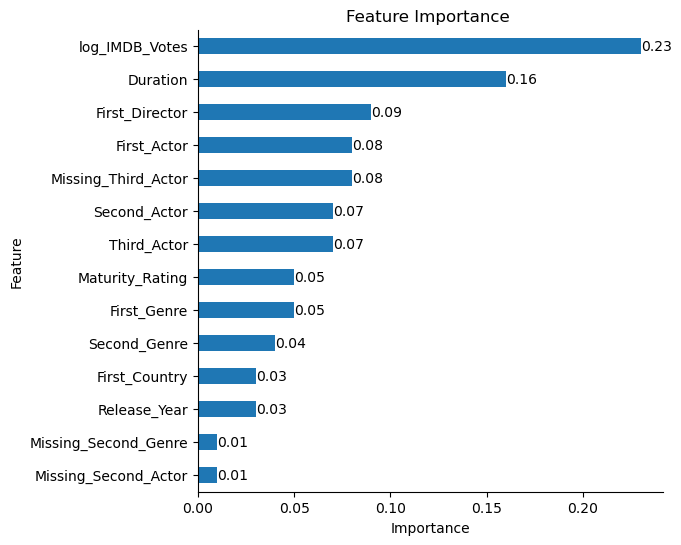

In [44]:
# Plot feature importance with log transformed IMDB_Votes values

feature_select(model=model_Vlog,X_train=X_train_Vlog)

___
### Feature Selection -  Revised Feature list for supervised and unsupervised modelling 

#### Missing values directionality 
There are 3 'Missing_' values:
- Missing_Second_Actor
- Missing_Third_Actor
- Missing_Second_Genre

Correlations coefficients are calculated using **Point Biserial Correlation** to determine what direction their relatioaship with the target variable may lie.

See below for testing with Point Biserial Correlation (binary encoded Categorical independent features against Continuous target) indicates that Missing_Second_Actor and Missing_Third_Actor seem to have a positive influence on IMDB rating, ie the chance of a better rating increases with no second/third actor listed. This might be due to *only* the headline actor/s being listed by the production company, or it may be an avante garde production which has only 1 or 2 actors and a niche audience which rates highly. Missing_Second_Genre seems has a much lower, but mildly positive, influence.

 **↓↓ Point Biserial Correlation Code follows below ↓↓** 


In [45]:
# calculate coefficients with Point Biserial Correlation to indicate direction of influence 
# of missing values

def pb_corr(df,target="IMDB_Rating"):
    missing = ['Missing_Second_Actor', 'Missing_Third_Actor', 'Missing_Second_Genre']
    pb = pd.DataFrame(columns=["Feature","Correlation","p"])
    for column in missing:
        corr, pval = pointbiserialr(df[column], df[target])
        pb.loc[len(pb)] = [column,corr,pval]
    return pb

pb_corr(nds_rfr).head()
   

,Feature,Correlation,p
0,Missing_Second_Actor,0.24,0.00
1,Missing_Third_Actor,0.25,0.00
2,Missing_Second_Genre,0.05,0.01


___
### Features Selected to be used in modelling:
The RFR importance function is the more reliable for predicting performance, as it considers non-linear effects and feature interactions (not just independent feature to target depenedencies).

Accepted, which are highlighted by MIR as having dependencies and RFR as having importance equal/above 0.04:
- IMDB_Votes (and log transformed)
- Duration
- First_Director
- First_Actor
- Missing_Third_Actor (MIR also indicates some dependency to the target)
- Second_Actor
- Third_Actor
- First_Genre
- Maturity_Rating
- Second_Genre 
- First_Country

Discarded immediately:
- Release_Year (very low MIR dependency - low RFR importance)
- Missing_Second_Genre (very low MIR dependency - very low low RFR importance)
- Missing_Second_Actor (moderately high MIR dependency - very low low RFR importance)
___

___
### Supervised Learning - Random Forest Regressor (RFR)

Ensemble - bagging method

#### Why Random Forest Regressor?
- handles both linear and complex / non-linear relationships, this makes it appropriate for the netflix dataset 
- robust against overfitting, ie compared to a single decision tree - it averages predictions and in doing so reduces overfitting risk
- less sensititve to outliers (IMDB_Votes, especially, has extreme outliers) as multiple (trees) predictions aggregated
- accuracy is the primary aim
- compute power is readily available

#### Hyper Parameter Optimisation

Randomized Search with cross-validation (RandomizedSearchCV) used to determine optimum values of RFR hyper parameters. **n_iter=100** (number of parameter combination settings tried) for a comprehensive search.  
Hyper parameter distribution:  
- 'n_estimators': [300, 600, 1000]  # number of trees - incorrect value can lead to under/overfitting         
- 'max_depth': [10, 20, 30, None]   # depth of trees - incorrect value can lead to under/overfitting        
- 'min_samples_split': [2, 5, 10]          
- 'min_samples_leaf': [1, 2, 4, 8]         
- 'max_features': ['sqrt', 0.3, 0.5, None] 
- 'bootstrap': [True]                     
- 'criterion': ['squared_error', 'absolute_error']

#### Evaluation of Results

**RMSE:** 0.90 (same for IMDB_Votes and log_IMDB_Votes)  
**MAE:** 0.67 (same for IMDB_Votes and log_IMDB_Votes)

**Mean Absolute Error** (MAE) determines the absolute different between the actual values and the predicted values. As an error measure which uses the same units as the target (i.e IMDB Rating points from 1 - 10), it is easy to interpret as an measure of accuracy. It is insensitive to outliers, i.e. 1 unit errors are treated the same as 2 unit errors, so large errors dont drastically change the metric. This is a drawback, hence its good to use in tandem with RMSE.  
**Root Mean Squared Error** (RMSE), like MAE, is in the units of the target variable (IMDB Rating), so is easier to interpret. It is more sensitive to larger errors, ie penalises larger errors, which is a good indicator of outliers.

For the Random Forest Regressor training, with the randomised search cross-validation optimised hyper-params, The RMSE of 0.9 is greater than the MAE of 0.68, this points towards outliers. 

The MAE itself indicates that the models accuracy is off by about 0.68 IMDB ratings, which is a fairly reasonable accuracy level.

The difference between MAE and RMSE, 0.23, indicates that the model is producing some larger errors, but would indicate these are not frequent or massive.

**The Residuals plot** (difference betwen actual and predicted values) [1], [2] backs up that the model is reasonably reliable and robust, with most value symmetrically scattered around the red zero line. The spread of residuals is somewhat even across the IMDb Rating range from 5 - 8, albeit denser around the centre of that range (nearer the mean/median IMDB Rating 6.25/6.4), indicating a fairly constant variance of errors. Additionally, the spread of values is fairly even either side of the red zero line across all ratings, showing low bias, ie no bias to under or over prediction. However, the range of incorrect predictions (y axis), at +/- 3 of the red zero line, indicates some noise which the model cant explain. These noisy outliers explain the RMSE being greater than MAE.    

**The Actual Vs Predictions plot** As with the Residuals plot, this plot shows a clustering of results around than 5-7.5 mean/median band, this shows good accuracy. The regression line is below the perfect accuracy (red dotted) for the higher end of IMDB ratings (i.e. IMDB 7 rating onwards) which shows the model is underpredicting some high ratings. Conversely, the regression line is below the perfect accuracy line, which shows a modest tendency to overestmate lower ratings (less than IMDB 5 rating). 


[1] GeeksforGeeks. (2022, February 17). How to Create a Residual Plot in Python. GeeksforGeeks. https://www.geeksforgeeks.org/python/how-to-create-a-residual-plot-in-python/  
‌[2] Wijaya, C. Y. (2025, April 21). Understanding Residual Plots. Statology. https://www.statology.org/understanding-residual-plots/  

#### **↓↓ Code described here follows below ↓↓** ##

In [46]:
nds_rfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3273 entries, 0 to 3272
Data columns (total 85 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Duration                   3273 non-null   int64  
 1   IMDB_Rating                3273 non-null   float64
 2   IMDB_Votes                 3273 non-null   int64  
 3   Release_Year               3273 non-null   int64  
 4   log_IMDB_Votes             3273 non-null   float64
 5   Missing_Second_Actor       3273 non-null   int64  
 6   Missing_Third_Actor        3273 non-null   int64  
 7   Missing_Second_Genre       3273 non-null   int64  
 8   Maturity_Rating__G         3273 non-null   int64  
 9   Maturity_Rating__NC-17     3273 non-null   int64  
 10  Maturity_Rating__PG        3273 non-null   int64  
 11  Maturity_Rating__PG-13     3273 non-null   int64  
 12  Maturity_Rating__R         3273 non-null   int64  
 13  Maturity_Rating__TV-14     3273 non-null   int64

In [64]:
# prepare dataframe for training
X = nds_rfr.drop(['IMDB_Rating','log_IMDB_Votes'], axis=1)
y = nds_rfr['IMDB_Rating']

# split dataset into test/train 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=112)

# specify hyper params distributions
params = {
    'n_estimators': [300, 600, 1000],     # KEY PARAMETER: number of decision trees in the random forest   
    'max_depth': [10, 20, 30, None],     # KEY PARAMETER: max possible depth of each tree     
    'min_samples_split': [2, 5, 10],        
    'min_samples_leaf': [1, 2, 4, 8],         
    'max_features': ['sqrt', 0.3, 0.5, None], 
    'bootstrap': [True],                      
    'criterion': ['squared_error', 'absolute_error']  
}
# instantiate method
rfr = RandomForestRegressor()
# set search params
rscv_rfr = RandomizedSearchCV(rfr,param_distributions=params, n_iter=100,cv=5,n_jobs=-1, \
                              random_state=34,scoring=['neg_root_mean_squared_error','neg_mean_absolute_error'], \
                                refit="neg_root_mean_squared_error", error_score = 'raise')
rscv_rfr.fit(X, y)
best_params_rfr = rscv_rfr.best_params_
# Print optimal hyperparameter values and accuracy score
print("Best parameters:", best_params_rfr)
print("Best RMSE:", rscv_rfr.best_score_)


Best parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 20, 'criterion': 'absolute_error', 'bootstrap': True}
Best RMSE: -0.9073621713211552


In [65]:
# train model using optimised hyper-params from randomised search cross-validation results 

X = nds_rfr.drop(['IMDB_Rating','log_IMDB_Votes','Release_Year','Missing_Second_Genre','Missing_Second_Actor'], axis=1)
y = nds_rfr['IMDB_Rating']

model_rfr_tuned, X_train_rfr_tuned, X_test_rfr_tuned, y_test_rfr_tuned, y_pred_rfr_tuned = rfr_predict(X,y,count=10,params=rscv_rfr.best_params_)

RMSE: 0.90
MAE: 0.67
First 10 predictions:
       Actual  Predicted  Error
909     5.00       5.82   0.82
1236    6.60       6.98   0.38
1080    7.70       6.15   1.55
2804    7.10       6.07   1.03
1342    7.00       6.70   0.30
2567    5.80       6.52   0.72
2975    6.40       6.73   0.33
1027    7.20       5.89   1.31
709     5.20       5.98   0.78
2800    5.30       6.16   0.86


c:\Users\luke\anaconda3\envs\comp647\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
# trainig the dataset on random forest regressor, with same optimised hyper params, but with log transformed IMDB Votes

X = nds_rfr.drop(['IMDB_Rating','IMDB_Votes','Release_Year','Missing_Second_Genre','Missing_Second_Actor'], axis=1)
model_rfr_Vlog_tuned, X_train_rfr_Vlog_tuned, y_test_rfr_Vlog_tuned, y_pred_rfr_Vlog_tuned = rfr_predict(X,y,count=10,params=rscv_rfr.best_params_)

RMSE: 0.90
MAE: 0.67
First 10 predictions:
       Actual  Predicted  Error
909     5.00       5.74   0.74
1236    6.60       7.00   0.40
1080    7.70       6.07   1.63
2804    7.10       6.15   0.95
1342    7.00       6.80   0.20
2567    5.80       6.50   0.70
2975    6.40       6.69   0.29
1027    7.20       6.08   1.12
709     5.20       6.04   0.84
2800    5.30       6.25   0.95


In [52]:
# function to plot 2 scatter plots:
# 1 - residual plot
# 2 - actual Vs predicted results with regresion line

def results_plots(algo,y_test,y_pred,mae,rmse):
    # plot residual values
    residuals = y_test - y_pred
    plt.figure(figsize=(7,6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
    plt.title(f"{algo} Residuals Plot")
    plt.xlabel("Predicted IMDB Rating")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.show()


    # plot actual vs predicted with regression line
    plt.figure(figsize=(7,6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], \
            color='red', linestyle=':', linewidth=2)
    # display regression line
    sns.regplot(x=y_test, y=y_pred, scatter=False, color='blue', label='regression line')
    plt.xlabel("Actual IMDB Rating")
    plt.ylabel("Predicted IMDB Rating")
    plt.title(f"{algo}: Actual Vs Predicted IMDB Ratings\nwith Regression Line\nMAE = {mae:.2f}, RMSE = {rmse:.2f}", fontsize=11)
    plt.legend()
    plt.show()




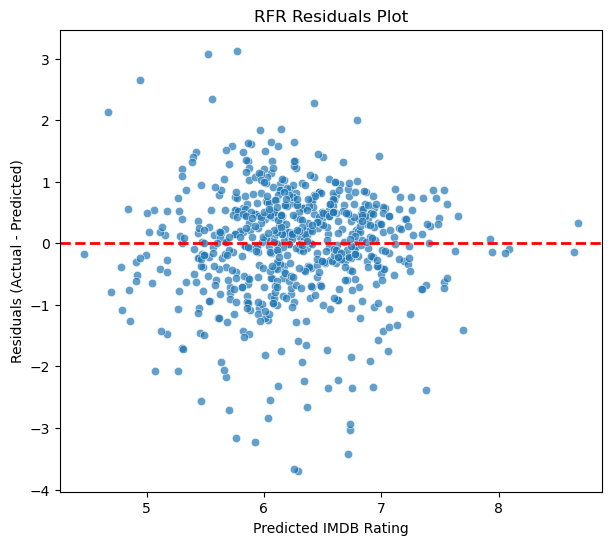

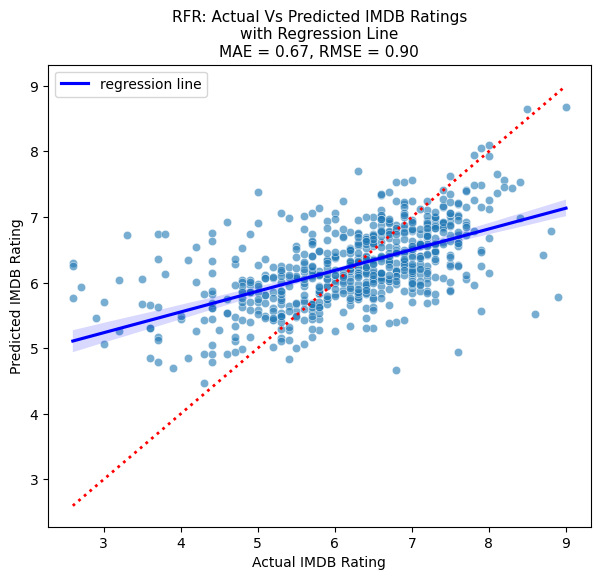

In [ ]:
# test with best RFR estimator and calculate results for evaluation

mae_rfr = mean_absolute_error(y_test_rfr_tuned, y_pred_rfr_tuned)
rmse_rfr = np.sqrt(mean_squared_error(y_test_rfr_tuned, y_pred_rfr_tuned))

# plot resdiuals and 'actual Vs predicted'
results_plots("RFR",y_test_rfr_tuned,y_pred_rfr_tuned,mae_rfr,rmse_rfr)

___
### Supervised Learning - XGBoost (XGB)

Ensemble - boosting method

#### Why XGBoost?
- handles both linear and complex / non-linear relationships, this makes it appropriate for the netflix dataset 
- to test if a sequential ensemble boosting method, which fixes the mistakes of the previous trees, reduces bias and improves accuracy relative to RFR
- handles unbalanced features well by automatically weighting residuals (via gradients), so less common IMDB rating levels (like <4 or >8) can still influence learning
- robust against overfitting
- less sensititve to outliers (IMDB_Votes, especially, has extreme outliers) 
- accuracy is the primary aim, especially as a potential improvement to the reasonably accurate results from RFR
- compute power is readily available

#### Hyper Parameter Optimisation

Randomized Search with cross-validation used to determine optimum values of RFR hyper parameters. **n_iter=100** (number of parameter combination settings tried) large for a more comprehensive result. Key hyper parameter (and value distributions) taken from [1], [2].  
Hyper parameter distribution:   
- 'n_estimators': [100, 300, 500, 800, 1000, 5000]  # number of rounds (trees) - incorrect value can lead to under/overfitting  
- 'max_depth': [3, 4, 5, 6, 8, 10, 16]  # depth of trees - incorrect value can lead to under/overfitting  
- 'learning_rate': [0.01, 0.05, 0.1, 0.2]  
- 'subsample': [0.6, 0.8, 1.0]  
- "min_child_weight": [1, 3, 5, 7]  
- 'colsample_bytree': [0.6, 0.8, 1.0]  
- 'gamma': [0, 0.1, 0.5, 1]          # regularization params to stop overfitting; setting incorrectly can lead to underfitting     
- 'reg_alpha': [0, 0.001, 0.01, 0.1, 1]   # regularization params to stop overfitting; setting incorrectly can lead to underfitting   
- 'reg_lambda': [0.1, 0.5, 1, 2, 5]  # regularization params to stop overfitting; setting incorrectly can lead to underfitting  
- 'tree_method': ["hist","exact"]    


#### Early Stopping
Early stopping (early_stopping_rounds=10), which allows the model to halt training once it stops improving [3], has been used here. Helps to prevent overfitting. 

#### Evaluation of Results

- Model training with default hyper params (and original IMDB_Rating values): 
    - **RMSE:** 0.96 (over 5% less accurancy compared to RFR)  
    - **MAE:** 0.72 (over 3% less accurancy compared to RFR)

- Model training after hyper parameter tuning/optimization (results same for original IMDB_Rating and log transformed values):
    - **RMSE:** 0.87 (0.01 IMDB rating point improvement over RFR)  
    - **MAE:** 0.67 (same as tuned RFR)
 

The evaluation metrics chosen were the same as for RFR: MAE and RMSE. Chosen for the same reasons and in order to allow for an approriate comparison to the RFR model.

The MAE and RMSE results show the same outcomes, with predictions generally within 2/3rds +/- of an IMDB rating point (on a ten point scale), which indicates that the model generalises well. 

The difference between MAE and RMSE, 0.22, a very slight improvement on RFR, indicates that the model is producing some larger errors, but would indicate these are not frequent or massive.

**The Residuals plot** (difference betwen actual and predicted values) backs up that the model is reasonably reliable and robust, with most value symmetrically scattered around the red zero line. The spread is somewhat even across the IMDb Rating range from 5 - 8, albeit denser around the centre of that range around the mean/median IMDB Rating (6.25/6.4) likely due to fewer data points at extreme IMDB Rating levels, indicating a fairly constant variance of errors. Additionally, the spread of values is fairly even either side of the red zero line, ie no bias to under or over prediction. The residual points above 2, and below -2, indicate a relatively small number of noise/outliers that the model cant explain, but this is marginally better than the +/- 3 range shows in the RFR residuals. This noise indicates why the RMSE > MAE.    

**The Actual Vs Predictions plot** As with the Residuals plot, this plot shows a clustering of results around than 5-7.5 mean/median band, this shows good accuracy. The regression line is below the perfect accuracy (red dotted) for the higher end of IMDB ratings (i.e. 7 onwards) which shows the model is underpredicting some high ratings. Conversely, the regression line is below the perfect accuracy line at hte lower end of ratings, which shows a modest tendency to overestmate lower ratings (less then 5). 

[1] Lasaosa, J. M. (2023, February 16). XGBoost: Theory and Hyperparameter Tuning | Towards Data Science. Towards Data Science. https://towardsdatascience.com/xgboost-theory-and-hyperparameter-tuning-bc4068aba95e/  
[2] GeeksforGeeks. (2025, June 12). XGBoost Parameters. GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/xgboost-parameters/  
[3] Common Mistakes & Best Practices for XGBoost | DataScienceBase. (2025). Datasciencebase.com. https://www.datasciencebase.com/supervised-ml/algorithms/gradient-boosting/XGBoost/common-mistakes/  

#### **↓↓ Code described here follows below ↓↓** ##

In [48]:
# create dataframe for training XGBoost
nds_xgb = nds_rfr.copy()

In [49]:
# train a model onXGBoost with default parameters to act as baseline before hyper parameter tuning


# function to train dataset with XGBoost
def xgb_predict(X,y,params={}):
    # split dataset into test/train
    X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=61)

    # train model using default parameters
    xgb = XGBRegressor(objective='reg:squarederror',eval_metric='rmse',n_jobs=-1, random_state=613, **params)
    xgb.fit(X_train_xgb, y_train_xgb)

    # predictions
    y_pred_xgb = xgb.predict(X_test_xgb.values)

    # calculate and display evaluation metrics
    mae = mean_absolute_error(y_test_xgb, y_pred_xgb)
    rmse = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
    evaluation = pd.DataFrame({
        "Actual": y_test_xgb[:10],
        "Predicted": y_pred_xgb[:10],
        "Error": np.abs(y_test_xgb[:10] - y_pred_xgb[:10])
        })
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"First 10 predictions:\n", evaluation)
    return xgb, X_test_xgb #return model and X_train for use outside function with XAI

# prepare dataframe for training with default parameters
X = nds_xgb.drop(['IMDB_Rating','IMDB_Votes','Release_Year','Missing_Second_Genre','Missing_Second_Actor'], axis=1)
y = nds_xgb['IMDB_Rating']
xgb = xgb_predict(X,y)




RMSE: 0.96
MAE: 0.72
First 10 predictions:
       Actual  Predicted  Error
594     7.20       6.33   0.87
1882    3.00       5.79   2.79
2526    2.80       6.11   3.31
2925    6.80       6.64   0.16
1617    5.10       4.80   0.30
1662    7.00       5.61   1.39
1431    7.10       5.50   1.60
1438    6.10       5.94   0.16
1947    6.90       6.27   0.63
2947    6.60       6.10   0.50


In [50]:
# use RandomizedSearchCV with XGBoost to tune / optimize hyper parameters 

# create dataframe for training XGBoost
nds_xgb = nds_rfr.copy()

# prepare dataframe for training and split into train/test sets
X = nds_xgb.drop(['IMDB_Rating','log_IMDB_Votes','Release_Year','Missing_Second_Genre','Missing_Second_Actor'], axis=1)
y = nds_xgb['IMDB_Rating']
# split dataset into test/train
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=61)
# further split the training set into train and validation for hyper parameter tuning
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_train_xgb, y_train_xgb)

# specify hyper parameter distributions
params = {
    'n_estimators': [100, 300, 500, 800, 1000, 5000], 
    'max_depth': [3, 4, 5, 6, 8, 10, 16],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5, 1],           
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1], 
    'reg_lambda': [0.1, 0.5, 1, 2, 5],
    'tree_method': ["hist","exact"] 
}

# instantiate method
xgb = XGBRegressor(objective='reg:squarederror',eval_metric='rmse',random_state=61,n_jobs=-1, \
                   early_stopping_rounds=10)
# set search params
rscv_xbg = RandomizedSearchCV(xgb,param_distributions=params,n_iter=100,cv=5,n_jobs=-1, \
                               random_state=58,scoring='neg_root_mean_squared_error', \
                                 error_score="raise")
# perform randomized search CV with early stopping
rscv_xbg.fit(X_train_xgb, y_train_xgb,eval_set=[(X_val_xgb, y_val_xgb)],
                  verbose=False)
best_params_xgb = rscv_xbg.best_params_
print("Best parameters:", best_params_xgb)
print("Best RMSE:", rscv_xbg.best_score_)





Best parameters: {'tree_method': 'exact', 'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best RMSE: -0.9052015278904797


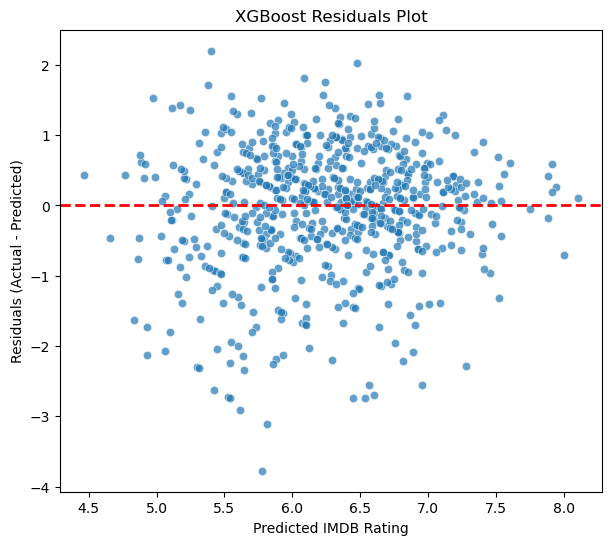

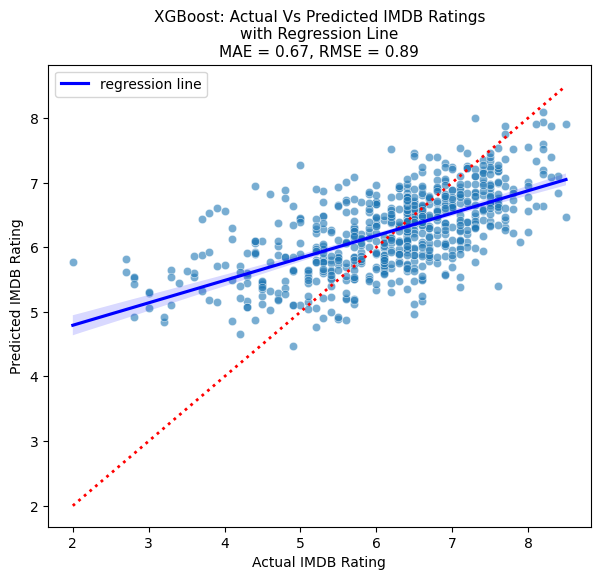

In [66]:

# test with best XBG estimator and calculate results for evaluation
y_pred_xgb = rscv_xbg.best_estimator_.predict(X_test_xgb)
mae_xgb = mean_absolute_error(y_test_xgb, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))

# plot resdiuals and 'actual Vs predicted'
results_plots("XGBoost",y_test_xgb,y_pred_xgb,mae_xgb,rmse_xgb)

In [54]:
# train model with original IMDB_Votes and using tuned hyper params
X = nds_xgb.drop(['IMDB_Rating','log_IMDB_Votes','Release_Year','Missing_Second_Genre','Missing_Second_Actor'], axis=1)
xgb_tuned, X_test_xgb_tuned = xgb_predict(X,y,params=rscv_xbg.best_params_)

RMSE: 0.87
MAE: 0.66
First 10 predictions:
       Actual  Predicted  Error
594     7.20       6.01   1.19
1882    3.00       5.01   2.01
2526    2.80       5.72   2.92
2925    6.80       6.59   0.21
1617    5.10       5.00   0.10
1662    7.00       5.18   1.82
1431    7.10       5.82   1.28
1438    6.10       6.05   0.05
1947    6.90       6.17   0.73
2947    6.60       5.74   0.86


In [55]:
# train model with log transformed IMDB_Votes and using tuned hyper params
X = nds_xgb.drop(['IMDB_Rating','IMDB_Votes','Release_Year','Missing_Second_Genre','Missing_Second_Actor'], axis=1)
xgb_tuned_Vlog, X_test_xgb_tuned_Vlog = xgb_predict(X,y,params=rscv_xbg.best_params_)



RMSE: 0.87
MAE: 0.66
First 10 predictions:
       Actual  Predicted  Error
594     7.20       5.94   1.26
1882    3.00       4.95   1.95
2526    2.80       5.97   3.17
2925    6.80       6.62   0.18
1617    5.10       5.18   0.08
1662    7.00       5.28   1.72
1431    7.10       5.98   1.12
1438    6.10       5.88   0.22
1947    6.90       6.23   0.67
2947    6.60       5.85   0.75


___
### Overfitting/Underfitting Prevention Summary

#### Algorithm Choice
**RandomForestRegressor** - combining multiple decision trees, and averaging for a final prediction, makes it robust to overfitting  
**XGBoostRegressor** - regularization parameters (see 'Hyper Parameter optimization/tuning', below) simplify the model to prevent overfitting

#### Outlier handling
Outliers can lead to the model overfitting to the noise created by outliers.
- Outliers, especially in IMDB_Votes feature are valid in the context of the IMDB Dataset and should be included in analysis
- **RandomForestRegressor** and **XGBoostRegressor** are generally robust to outliers
- a log transformed IMDB_Votes feature was created to soften the impact of outliers to reduce overfitting. Testing results show no real difference between using log transformed versus original IMDB_Votes.

#### Dimensionality  
Description column removed as it has extreme cardinality, which would likely introduce high dimensionality (or require too much work to remove filler words and extract keywords for little potential relationship to target variable) which can lead to overfitting.

#### Feature Selection  
Feature selection - Mutual Information and RFR feature_importances_ for feature selection used to remove uninformative columns, which prevents noise memorisation and produces better generalisation by focussing on most relevant features of the data and avoiding focus on noise.

#### Hyper Parameter optimization/tuning
RFR and XGBoost have two key parameters:
- **n_estimators** - the number of trees (or rounds, for XGB). Generally, more trees/rounds improves accuracy.
- **max_depth** - deeper trees. Deeper trees can capture more complex data relationships. 

RFR/XGBoost can underfit if the number of trees(rounds) is constrained (not enough trees) or too shallow (being unable to capture the underlying patterns in the data well). Conversely, if the tree depth is too high then the model might overfit the data, capturing noise, which leads to poor testing performance. 

**XGBoost Early Stopping** (early_stopping_rounds) was also implemented to help stop overfitting from too many rounds/too shallow by stopping training when performance stops improving.  

XGBoost - other hyper parameters that may contribute to over/underfitting:
- subsample -  the fraction of observations to be sampled for each tree. This value too low can lead to underfitting, too high overfitting.
- regularization parameters, including: reg_alpha/reg_lambda/gamma/min_child_weight, defined to stop the model learning noise and reducing accuracy (ie simplifying the model), to prevent overfitting. Set too low they can also contribute to underfitting and loss of accuracy. 

**Randomized search with Cross Validation** (RandomizedSearchCV) is used to find balanced values for the above hyper parameters, which can then be tested to verify the model is not over/underfitted.  
- RandomizedSearchCV was chosen over GridSearchCV as it samples subsets of parameter combinations randomly (not exhaustively test every parameter combination) which can make it more robust to noise and overfitting.   
- **Cross Validation** - splitting training data into multiple sets and using a different subset for validation, can provide a more accurate estimate of model performance and help to avoid overfitting.

___

In [57]:
def shap_condenser(model,X_test,features):	
	"""
	LA20251101
	function to take tested model data, sum multiple binary encoded column values 
	that result from a single categorical feature into a single shap value 
	for that feature, then create a shap Explantion file to be returned
	ARGS: 
		a trained model from RFR or XGBoost
		b X_Test values 
		c list of feature names from model dataframe
	Funtion
	RETURNS: 
		shap.Explanation object for use in interpretaion plots
	"""
	shap.initjs()
	# create shap explainer from model and X_test values 
	shap_explainer = shap.Explainer(model.predict,X_test, feature_names=features)
	shap_values = shap_explainer(X_test)

	# create dataframe with shap values and column names in order to group binary encoded columns
	shap_df = pd.DataFrame(shap_values.values, columns=features)

	# for each binary encoded feature with multiple columns, create dictionary of {feature name: [list of column names]}
	feature_groups = {
		'First_Genre': [col for col in shap_df.columns if col.startswith('First_Genre')],
		'Second_Genre': [col for col in shap_df.columns if col.startswith('Second_Genre')],
		'First_Actor': [col for col in shap_df.columns if col.startswith('First_Actor')],
		'Second_Actor': [col for col in shap_df.columns if col.startswith('Second_Actor')],
		'Third_Actor': [col for col in shap_df.columns if col.startswith('Third_Actor')],
		'First_Director': [col for col in shap_df.columns if col.startswith('First_Director')],
		'Maturity_Rating': [col for col in shap_df.columns if col.startswith('Maturity_Rating')],
		'First_Country': [col for col in shap_df.columns if col.startswith('First_Country')]
	}

	# create new dataframe of features to store sum values of its binary columns
	shap_groups = pd.DataFrame(index=shap_df.index)
	# iterate and sum values per feature set of binary columns and insert into shap_groups dataframe
	for feature, cols in feature_groups.items():
		# Extract SHAP values as a plain array and sum across binary-encoded columns
		shap_groups[feature] = shap_values.values[:, [shap_df.columns.get_loc(col) for col in cols]].sum(axis=1)

	# create set to store binary column names [LA20251101 list throws truth error, if used]
	grouped_columns = set()
	for cols in feature_groups.values():
		for col in cols:
			grouped_columns.add(col)

	# create a list of non-binary encoded columns
	remaining_features = []
	for col in shap_df.columns:
		if col not in grouped_columns:
			remaining_features.append(col)

	# concat the grouped binary feature columns (ie with summed values) with non-binary encoded features
	shap_combined = pd.concat([shap_groups, shap_df[remaining_features]], axis=1)

	# create dataframe for summed X_test values to use in summary data shap plots like beeswarm (ie NOT waterfall on specific datapoint)
	X_test_grouped = pd.DataFrame(index=X_test.index)

	# sum binary-encoded X features to match SHAP groups
	for feature, cols in feature_groups.items():
		X_test_grouped[feature] = X_test[cols].sum(axis=1)

	# concat X_train grouped binary feature columns (ie with summed values) with non-binary encoded features
	X_test_grouped = pd.concat([X_test_grouped, X_test[remaining_features]], axis=1)

	# create new shap explanation object including summed binary column data
	shap_condensed_exp = shap.Explanation(
		values=shap_combined.values,
		base_values=np.array(shap_values.base_values),
		feature_names=shap_combined.columns.tolist(),
		data=X_test_grouped.values
	)
	return shap_condensed_exp

PermutationExplainer explainer: 656it [18:27,  1.70s/it]                         


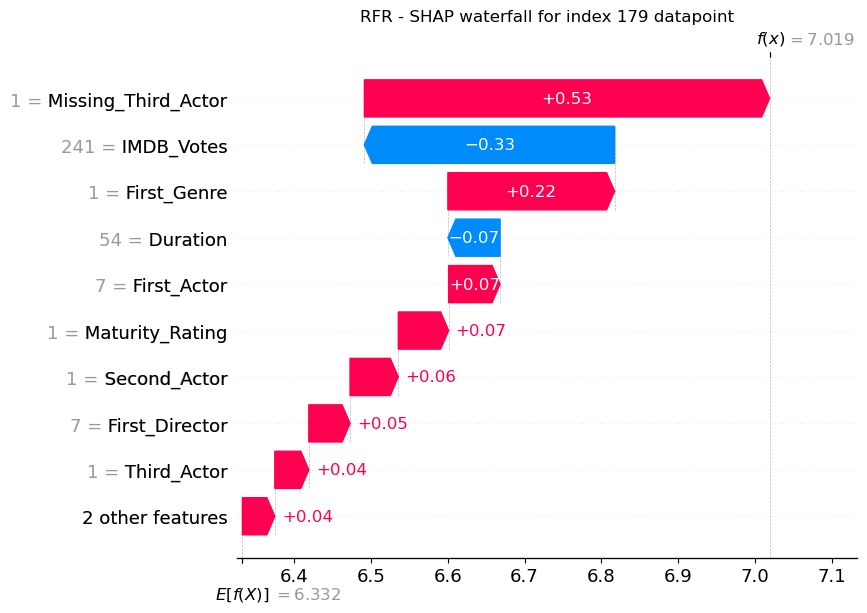

In [67]:
# waterfall plot for a single RandomForestRegressor model instance/datapoint

# create a list of feature names
rfr_features = nds_rfr.drop(['IMDB_Rating','log_IMDB_Votes','Release_Year','Missing_Second_Genre','Missing_Second_Actor'], axis=1).columns

# create shap Explainer object
shap_exp_rfr = shap_condenser(model_rfr_tuned,X_test_rfr_tuned,rfr_features)

# create waterfall plot for test instance/datapoint at specified index
test_instance_index = 179
fig = plt.figure()
plt.title(f"RFR - SHAP waterfall for index {test_instance_index} datapoint") 
shap.plots.waterfall(shap_exp_rfr[test_instance_index])

plt.show()

PermutationExplainer explainer: 656it [01:04,  8.56it/s]                         


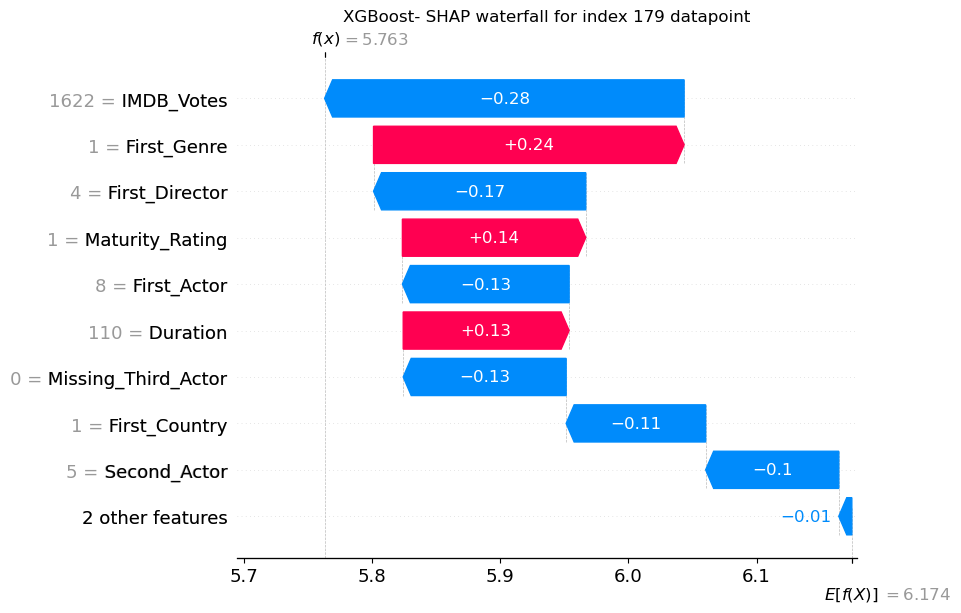

In [ ]:
# waterfall plot for a single XGBoost model instance/datapoint

# create a list of feature names
xgb_features = nds_xgb.drop(['IMDB_Rating','log_IMDB_Votes','Release_Year','Missing_Second_Genre','Missing_Second_Actor'], axis=1).columns

# create shap Explainer object
shap_exp_xgb = shap_condenser(xgb_tuned,X_test_xgb_tuned,xgb_features)

# create waterfall plot for test instance/datapoint at specified index
test_instance_index = 179
fig = plt.figure()
plt.title(f"XGBoost - SHAP waterfall for index {test_instance_index} datapoint") 
shap.plots.waterfall(shap_exp_xgb[test_instance_index])
plt.show()


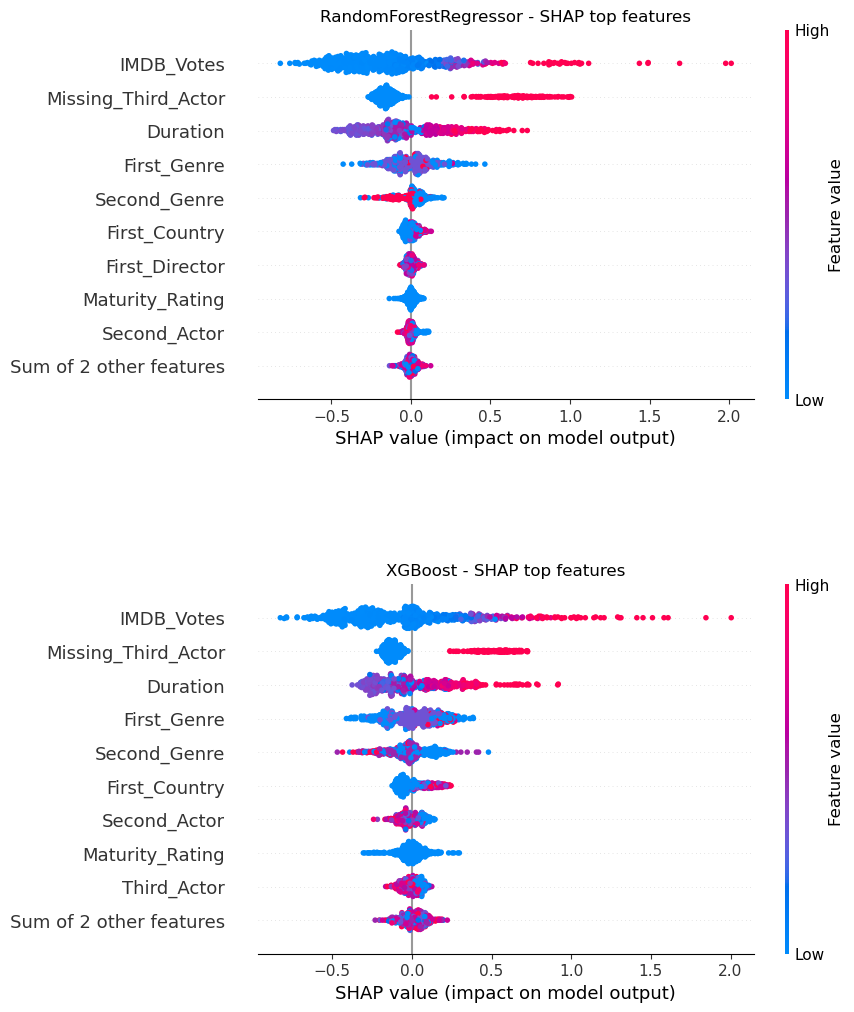

In [ ]:
# SHAP plots showing top features for RandomForestRegressor & XGBoost (original IMDB_Votes) models 
fig = plt.figure()


ax0 = fig.add_subplot(211)
plt.title("RandomForestRegressor - SHAP top features") 
shap.plots.beeswarm(shap_exp_rfr,show=False)


ax1 = fig.add_subplot(212)
plt.title("XGBoost - SHAP top features")
shap.plots.beeswarm(shap_exp_xgb,show=False)
 

plt.gcf().set_size_inches(8,12)
plt.subplots_adjust(hspace=0.5)
plt.show()

___
NOTE: explained here are the above SHAP plots from the tuned XGBoost model
#### SHAP Waterfall Plot: Explanation of individual Datapoint

**Baseline IMDB Rating** : 6.2 (i.e the average IMDB Rating for the dataset)

**SHAP values contibutions**:
- IMDB_Votes - reasonable negative contribution (-0.28) reduces rating 
- First_Genre - almost cancels out IMDB_Votes contribution with reasonable positive (+0.24)
- First_Director - moderate negative contribution (-0.17)
- Maturity_Rating - moderate positive contribution almost cancels out First_Director (+0.14)
- First_Actor - moderate neagtive contribution (-0.13)
- Duration - moderate positive contribution (+0.13)
- Missing_Third_Actor - moderate neagtive contribution (-0.13)
- First_Country - smaller negative contribution (-0.11)
- Second_Actor - smaller negative contribution (-0.1)
- remaining features - negligible negative contribution (-0.01)


**SHAP Values sum** = (-0.28 +0.24 -0.17 +0.14 -0.13 +0.13 -0.13 -0.11 -0.1 -0.01) = - 0.42

**Final prediction** = base_value (6.174) + SHAP Values sum (-0.42) = IMDB Rating 5.76


#### SHAP Beeswarm Plot: Importance of features and directionality of relationships to target
The most important independent feature (IMDB Votes) is agreed on by Mutual Information analysis, RandomForestRegressor feature_importances and SHAP beeswarms (from both RFR and XGBoost). In the SHAP beeswarm, the most important features are listed from top down.

The SHAP Beeswarm shows that as the number of votes increases, the dots to the right of the zero line turn increasingly red. The dots to the right are blue. With red indicating a higher number of votes, and blue lower values, this indicates that movies with higher IMDB Votes have a higher predicted IMDB Ratings. 

Duration follows a similar, but less stronger, influence, indicating that longer duration movies lead to higher IMDB Rating predictions.

Missing_Third_Actor (where value = 1 for NO third actor) shows 1 values having a positive influence. Indicating that missing a third actor tends to slightly increase predictions. As mentioned earlier, this might be due to more avate gard (higher quality) productions only having 1 or 2 actors, or some higher quality production companies only listing one or two lead actors. 

Most of the remaining catagorical features on the SHAP beeswarm are binary encoded and would need to be decoded to see what influence individual categories have on predictions, but some high level trends are:
- First/Second Genre, have mixed high/low value results on both sides of the zero line, indicating that genre matters, but direction depends on the genre category.
- Second/Third Actors - similar to First/Second Genre, but with smaller effects, certain actors correlate with higher predictive power for higher or lower IMDB ratings.

___

___
#### Final Thoughts
- accuracy gained from RandomForestRegressor and XGBoost is respectable
- the dataset is relatively small (3.3k) and accuracy might be improved with a larger dataset to train on.


#### Future Actions
- larger dataset (there are other/larger IMDB datasets on kaggle) to retrain the model and see if accuracy improves
- HDBSCAN to find similar groups and clusters 